In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import pickle
import glob 
# Use BADS
import concurrent.futures
from pybads import BADS

import json
import pandas
from collections import Counter

figpath = os.path.join("fig")
fitspath = os.path.join("modelfits")
data_savepath = os.path.join("data")
datapath = os.path.join("..","experiment","data", "exp1")

## Stimuli

In [2]:
nu = 0.1
beta = 5
logistic_growth = lambda t, theta: theta[:,0] + theta[:,1]/(1+np.exp(-theta[:,2]*(3*t-theta[:,3])))

def log_normpdf(x, mean, std):
    log_normpdf_unnorm = -np.log(std)-0.5*np.log(2*np.pi)-0.5*((x-mean)/std)**2
    return log_normpdf_unnorm

def traj_r_T_estimation(rs_traj, t_now=10, T_end=20, dt=1, thetas_support=None, nu=nu, thetas_traj=None, is_plot=False):
    '''Assume that ts is a vector from t=0 to t=t_now, with spacing of 1 unit. 
       Hence, the length of rs_traj should be at least t_now.
       Also, T_end must be larger than t_now.
    '''
    if(t_now<0): # Prior; no evidence r observed so far.
        ts_train = []
    else:
        ts_train = np.arange(0,t_now,dt)[:,None]
    (num_thetas, thetas_dim) = thetas_support.shape
    
    
    # Grid of integration. Needs to be more finer. 
    r_T_grid = np.linspace(-3,5,400)
    
    # 1) Find p(theta|r) as a function of theta.
    log_p_thetaj_given_rj = np.zeros((num_thetas))
    for theta_val_idx in range(num_thetas):
            # Current theta value
            theta_val = thetas_support[theta_val_idx][None,:]
            # Instantiate the flat prior p(theta). 
            log_p_thetaj_given_rj[theta_val_idx] = -np.log(num_thetas)
            for t0_idx in range(len(ts_train)):
                t0 = ts_train[t0_idx]
                r_t0_traj = rs_traj[t0_idx]
                rho_t_given_thetaj = logistic_growth(t0, theta_val)
                log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)
    log_p_thetaj_given_rj_normalized =  log_p_thetaj_given_rj - scipy.special.logsumexp(log_p_thetaj_given_rj)    

    # 2) Find p(r_T | rho(T; theta))
    log_r_T_given_thetaj = np.zeros((len(r_T_grid), num_thetas))
    for theta_val_idx in range(num_thetas):
        # Current theta value
        theta_val = thetas_support[theta_val_idx][None,:]
        rho_T_given_thetaj = logistic_growth(T_end, theta_val)
        log_r_T_given_thetaj[:, theta_val_idx] = log_normpdf(r_T_grid, rho_T_given_thetaj, nu)

    # 3) Find p(r_T | r)
    log_p_r_T_and_theta_given_r = log_r_T_given_thetaj + log_p_thetaj_given_rj_normalized[None,:]
    p_r_T_given_r = np.sum(np.exp(log_p_r_T_and_theta_given_r), axis=-1) # Integrate over possible theta values
    p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
    post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)
    post_mode = r_T_grid[np.argmax(p_r_T_given_r)]  
    
    
    # Sanity check:
    if(is_plot):
        print("Posterior mean for r_T: ",  post_mean)
        print("Posterior mode for r_T: ",  post_mode)
        
        sorted_array = -np.sort(-log_p_thetaj_given_rj_normalized.reshape(-1))
        print("theta_true:", thetas_traj)
        
        fig, ax = plt.subplots(1,2,figsize=(8,4))
        ax[0].plot(ts, logistic_growth(ts, thetas_traj[None,:]), "k-", label="true traj")
        ax[0].plot(np.squeeze(ts[ts_train]), np.squeeze(rs_traj[ts_train]), "r.", label="training data")
        theta_postmean = np.sum(np.exp(log_p_thetaj_given_rj_normalized)[:,None]*thetas_support, axis=0)[None,:]
        ax[0].plot(ts, logistic_growth(np.squeeze(ts), theta_postmean), "C0--", label="rho(t; E[theta|r])")
        for traj_idx in range(1):
            theta_map_idx = np.where(log_p_thetaj_given_rj_normalized == sorted_array[traj_idx])
            theta_map = thetas_support[theta_map_idx]
            print("theta_map: ",np.squeeze(theta_map))
            ax[0].plot(ts, logistic_growth(np.squeeze(ts), theta_map), "C1--", label="rho(t; Mode[theta|r])")
        ax[0].plot(ts, trajs, "k-", alpha=0.1)
        ax[0].set_ylim([0,1])
        ax[0].set_ylabel("Performance")
        ax[0].set_xlabel("Time")
        ax[0].legend()
        
        ax[1].plot(p_r_T_given_r, r_T_grid, "k-", label="p(r_T | r)")
        ax[1].plot([0,5],[rs_traj[T_end], rs_traj[T_end]], "k--", label="true r_T")
        ax[1].plot([0,5],[post_mean, post_mean], "C0--", label="E[r_T|r]")
        ax[1].plot([0,5],[post_mode, post_mode], "C1--", label="Mode[r_T|r]")
        ax[1].set_ylabel("r_T")
        ax[1].set_xlabel("p(r_T | r)")
        ax[1].set_ylim([0,1])
        ax[1].legend()
        
        plt.suptitle("theta_true="+str(np.round(thetas_traj,2))+", t_now="+str(t_now)+", T_end="+str(T_end))
        plt.tight_layout()
    
    if(is_plot):
        return post_mean, post_mode, fig
    else:
        return post_mean, post_mode


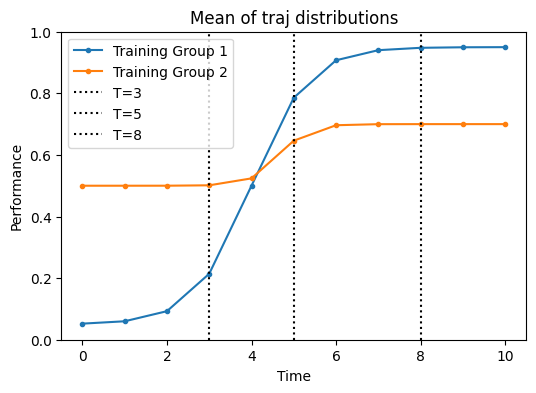

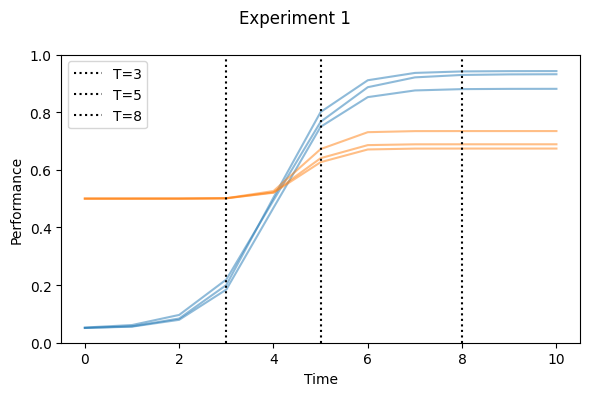

2

In [3]:
# Experiment 2A questions

dt=1
ts = np.arange(0,11,dt)[:,None]

# 1) The means of trajs
theta0 = np.array([[0.05,0.9,0.5,12]]) # theta[2]=0.8
theta1 = np.array([[0.5,0.2,1,14]])
theta_sigmas = np.array([0,0.03,0.03,0.03])
T_ends = np.array([3,5,8])

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(logistic_growth(ts, theta0),"C0.-", label="Training Group 1")
plt.plot(logistic_growth(ts, theta1),"C1.-", label="Training Group 2")
for T_end in T_ends:
    plt.plot([T_end,T_end], [0,1.4], "k:", label="T="+str(T_end))
ax.set_xlabel("Time")
ax.set_ylabel("Performance")
ax.set_ylim([0,1])
ax.set_title("Mean of traj distributions")
plt.legend()
plt.show()

# 2) Actual data
num_thetas = 3
theta_dims = theta0.shape[1]
np.random.seed(1)
thetas_0 = np.random.normal(loc=theta0, scale=theta_sigmas, size=(num_thetas,theta_dims))
thetas_1 = np.random.normal(loc=theta1, scale=theta_sigmas, size=(num_thetas,theta_dims))
trajs_0 = logistic_growth(ts, thetas_0)
trajs_1 = logistic_growth(ts, thetas_1)
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(trajs_0,"C0-", alpha=0.5)
plt.plot(trajs_1,"C1-", alpha=0.5)

for T_end in T_ends:
    plt.plot([T_end,T_end], [0,1.4], "k:", label="T="+str(T_end))
ax.set_xlabel("Time")
ax.set_ylabel("Performance")
ax.set_ylim([0,1])
plt.legend()
plt.suptitle("Experiment 1")

plt.tight_layout()
#plt.savefig(os.path.join(figpath,"example_trajs_exp1"), dpi=300)
plt.show()

Thetas = {"0": thetas_0, "1": thetas_1}
Trajs = {"0": trajs_0, "1": trajs_1}
len(Trajs)

# Human data

In [17]:
filename = os.path.join(data_savepath,"exp1_data_df.csv")
exp1_data_df = pd.read_csv(filename)

n_subj = len(np.unique(exp1_data_df["SubjectID"]))
print(n_subj)
n_questions = len(T_ends)

choices = np.zeros((n_subj,n_questions))
for question in range(n_questions):
    choices[:,question] = exp1_data_df[exp1_data_df["T_end"]==T_ends[question]]["chooseVelocity"].to_numpy()
choices_mean = np.mean(choices, axis=0) # Velocity agent is 0, Exploitation agent is 1.
choices_std = np.std(choices, ddof=1, axis=0) # Use sample std: denom is (N-1)
choices_sem = choices_std/np.sqrt(n_subj)
print(choices_mean)


# Count gender
ages = exp1_data_df[exp1_data_df["T_end"]==3]["Age"].to_numpy()
genders = exp1_data_df[exp1_data_df["T_end"]==3]["Gender"].to_numpy()
comments = exp1_data_df[exp1_data_df["T_end"]==3]["Comments"].to_numpy()
letter_counts = Counter(genders)
df_gender = pandas.DataFrame.from_dict(letter_counts, orient='index')
print(df_gender)

100
[0.33 0.64 0.77]
             0
F           46
M           53
Non-binary   1


In [18]:
ages

array([37, 44, 36, 46, 38, 39, 46, 40, 30, 35, 63, 33, 37, 50, 38, 46, 35,
       58, 43, 30, 53, 57, 70, 37, 37, 36, 36, 46, 45, 41, 39, 50, 26, 33,
       47, 60, 30, 42, 37, 25, 30, 34, 40, 54, 36, 38, 50, 38, 35, 64, 47,
       56, 46, 30, 38, 59, 33, 50, 46, 37, 40, 54, 49, 33, 41, 66, 42, 35,
       40, 54, 58, 33, 36, 36, 57, 30, 30, 46, 39, 35, 33, 39, 56, 37, 32,
       38, 40, 41, 47, 56, 37, 65, 64, 41, 29, 33, 60, 36, 37, 47])

In [20]:
# Save data and trajectories
a = {"mturk_IDs": [], "Thetas": Thetas, "Trajs": Trajs, "theta_sigmas": theta_sigmas, "T_ends":T_ends, "ts": ts, "choices": choices, "ages": ages, "genders": genders, "comments": comments}
with open(os.path.join(data_savepath,'exp1_data.pickle'), 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(data_savepath,'exp1_data.pickle'), 'rb') as handle:
    b = pickle.load(handle)
print(b)

{'mturk_IDs': [], 'Thetas': {'0': array([[ 0.05      ,  0.88164731,  0.48415485, 11.96781094],
       [ 0.05      ,  0.83095384,  0.55234435, 11.97716379],
       [ 0.05      ,  0.89251889,  0.54386324, 11.93819578]]), '1': array([[ 0.5       ,  0.18847837,  1.03401308, 13.96700326],
       [ 0.5       ,  0.17366425,  1.00126641, 14.01748446],
       [ 0.5       ,  0.23434171,  1.02704772, 14.01507483]])}, 'Trajs': {'0': array([[0.05267641, 0.05111151, 0.05134957],
       [0.06132547, 0.05579554, 0.05685638],
       [0.09644766, 0.07951663, 0.08397652],
       [0.21930181, 0.184502  , 0.20017933],
       [0.49425859, 0.46809718, 0.50375881],
       [0.76656825, 0.74927149, 0.80055053],
       [0.88655213, 0.85214701, 0.91067257],
       [0.92066507, 0.87530169, 0.93610508],
       [0.92905279, 0.87986998, 0.94125694],
       [0.93103884, 0.88074693, 0.94227175],
       [0.93150485, 0.88091437, 0.94247053]]), '1': array([[0.5000001 , 0.50000014, 0.50000013],
       [0.50000224, 0.500002

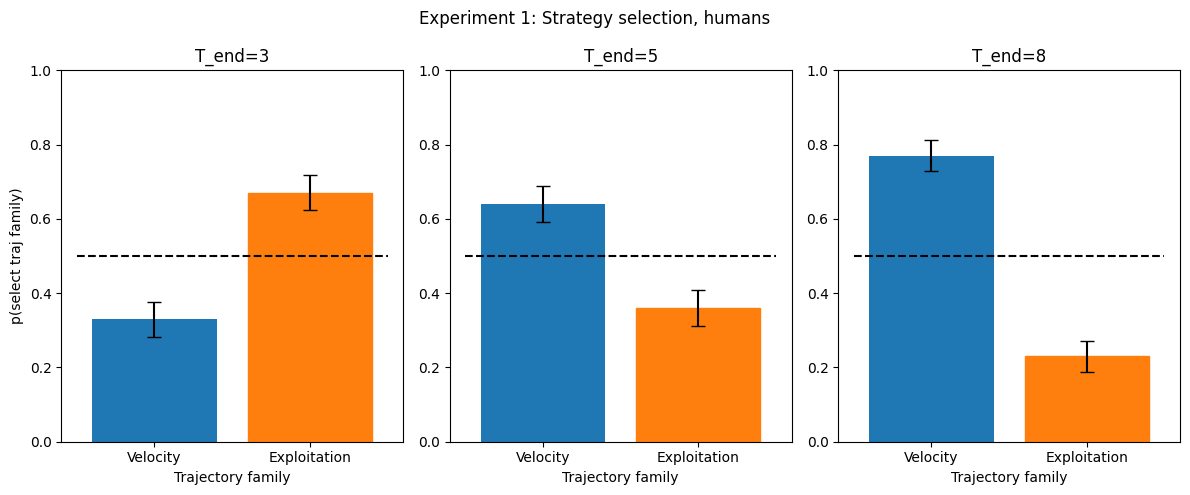

In [16]:
# Experiment 1, human choice probs

fig,ax=plt.subplots(1,3, figsize=(12,5))
for T_end_idx in range(len(T_ends)):
    T_end = T_ends[T_end_idx]
    
    bar=ax[T_end_idx].bar([0,1],[choices_mean[T_end_idx], 1-choices_mean[T_end_idx]], color="C0")
    bar[1].set_color('C1')
    ax[T_end_idx].errorbar([0,1],[choices_mean[T_end_idx], 1-choices_mean[T_end_idx]], yerr=[choices_sem[T_end_idx],choices_sem[T_end_idx]], color="k", linestyle="", capsize=5)
        
    ax[T_end_idx].plot([-0.5,1.5],[0.5,0.5], "k--")
    ax[0].set_ylabel("p(select traj family)")
    ax[T_end_idx].set_ylim([0,1])
    ax[T_end_idx].set_xticks([0,1], labels=["Velocity","Exploitation"])
    ax[T_end_idx].set_xlabel("Trajectory family")
    ax[T_end_idx].set_title("T_end="+str(T_end))
    
plt.suptitle("Experiment 1: Strategy selection, humans")
plt.tight_layout()
#plt.savefig(os.path.join(figpath,"exp1_humanprobs"), dpi=300)
plt.show()


# Model fits

In [6]:
def prob_choose_velocity_logistic(theta = [0.1,10,0], T_end=T_end, start_agent="velocity", model="bayesian_postmean", include_offset_param = True, Thetas=Thetas, Trajs=Trajs, rs_traj=[], t_now=-1, dt=dt, is_plot=False):
    nu = theta[0]
    slope = theta[1]
    if(include_offset_param):
        offset = theta[2]
    else:
        offset = 0
        
    
    prior_mean_trajs_raw = np.zeros((len(Trajs), 1, 1, len(ts)))
    prior_mode_trajs_raw = np.zeros((len(Trajs), 1, 1, len(ts)))

    # Loop over each trajectory family / agent. 
    for traj_family_idx in range(len(Trajs)):
        thetas = Thetas[str(traj_family_idx)]
        trajs = Trajs[str(traj_family_idx)]
        for T_end_idx in range(len(ts)):
            T_end_temp = ts[T_end_idx]
            prior_mean_trajs_raw[traj_family_idx,0,0,T_end_idx], prior_mode_trajs_raw[traj_family_idx,0,0,T_end_idx] = traj_r_T_estimation(rs_traj=rs_traj, t_now=-1, T_end=T_end_temp, dt=dt, nu=nu, thetas_support=thetas, is_plot=is_plot)
    softmax_probs_exploit = np.exp(beta*np.squeeze(prior_mean_trajs_raw[0,:])) / (np.exp(beta*np.squeeze(prior_mean_trajs_raw[0,:])) + np.exp(beta*np.squeeze(prior_mean_trajs_raw[1,:])))
    
    if(start_agent=="velocity"):
        velocity_final_height = prior_mean_trajs_raw[0,0,0,T_end]
        exploitation_final_height = prior_mean_trajs_raw[1,0,0,T_end-t_now]
        #softmax_prob = np.exp(beta*velocity_final_height) / (np.exp(beta*velocity_final_height) + np.exp(beta*exploitation_final_height))
    else: 
        velocity_final_height = prior_mean_trajs_raw[0,0,0,T_end-t_now]
        exploitation_final_height = prior_mean_trajs_raw[1,0,0,T_end]
        #softmax_prob = np.exp(beta*exploitation_final_height) / (np.exp(beta*velocity_final_height) + np.exp(beta*exploitation_final_height))
         
                        
    if(model=="bayesian_postmean"):
        if(start_agent=="velocity"):
            final_height_diff = velocity_final_height - exploitation_final_height
        else:
            final_height_diff = exploitation_final_height - velocity_final_height
        prob_stay = 1 / (1 + np.exp(offset - slope * final_height_diff))
    elif(model=="exploitation" or model=="exploitation_heuristic"):
        if(start_agent=="velocity"):
            initial_height_diff = np.squeeze(prior_mean_trajs_raw)[0,0] - np.squeeze(prior_mean_trajs_raw)[1,0]
        else:
            initial_height_diff = np.squeeze(prior_mean_trajs_raw)[0,0] - np.squeeze(prior_mean_trajs_raw)[1,0]
        prob_stay = 1 / (1 + np.exp(offset -slope * initial_height_diff))
    elif(model=="velocity"):
        velocity_traj0_Tend = (velocity_final_height-prior_mean_trajs_raw[0,0,0,0])/(T_end-t_now)
        velocity_traj1_Tend = (exploitation_final_height-prior_mean_trajs_raw[1,0,0,0])/(T_end-t_now)
        if(start_agent=="velocity"):
            velocity_diff = velocity_traj0_Tend - velocity_traj1_Tend
        else:
            velocity_diff = velocity_traj1_Tend - velocity_traj0_Tend
#         print(velocity_diff)
        prob_stay = 1 / (1 + np.exp(offset - slope * velocity_diff))
    elif(model=="velocity_heuristic"):
        # Velocity heuristic, which looks at past velocity, is undefined for strategy selection (where t_now=0)
        prob_stay = 1 / (1 + np.exp(offset - slope * 0))

    return prob_stay


# I am using this function to check for strategy selection: p(seelct velocity agent)
prob_choose_velocity_logistic(theta=[0.1,10,0], T_end=5, t_now=0, start_agent="velocity", model="bayesian_postmean")

C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


np.float64(0.7789490604135361)

In [7]:
n_stay = n_subj * choices_mean
print(n_stay)
n_subjs=[n_subj,n_subj,n_subj]

def crossentropy_loss(theta, T_ends=[3,5,8], t_nows=[0,0,0], start_agents=["velocity"], model="bayesian_postmean", true_n_stay=n_stay, n_subjs=[n_subj,n_subj,n_subj], include_offset_param = True):
    nu = theta[0]
    slope = theta[1]
    if(include_offset_param):
        offset = theta[2]
    else: 
        offset = 0;
    loss = 0;
    for start_agent_idx in range(len(start_agents)):
        for T_end_idx in range(len(T_ends)):
            model_prob_pred = prob_choose_velocity_logistic(theta=theta, start_agent=start_agents[start_agent_idx], include_offset_param=include_offset_param, T_end=T_ends[T_end_idx], t_now=t_nows[T_end_idx], model=model)
            n_choosestay = true_n_stay[T_end_idx]
            n_subj = n_subjs[T_end_idx]
            # The idea here is doing cross-entropy loss over each participant's response, and then summing them up.
            loss = loss + (-np.log(model_prob_pred)*n_choosestay - np.log(1-model_prob_pred)*(n_subj-n_choosestay))
    return loss
        

[33. 64. 77.]


In [8]:
T_ends = [3,5,8]
t_nows = [0,0,0]
start_agents=["velocity"]
models = ["bayesian_postmean","velocity","exploitation_heuristic","velocity_heuristic"]
n_inits = 10

include_offset_param = True

if(include_offset_param):
    lb = [1e-3, 1e-3, -10]
    ub = [1.5, 50, 10]
    suffix_offset = "_offset"
else:
    lb = [1e-3, 1e-3]
    ub = [1.5, 50]
    suffix_offset = "_nooffset"
    
constraint = scipy.optimize.Bounds(lb=lb, ub=ub)

params_init = np.zeros((len(models), n_inits, len(lb)))
params_fitted = np.zeros((len(models), n_inits, len(lb)))
crossentropy_fitted = np.zeros((len(models), n_inits))
for model_idx in range(len(models)):
    model = models[model_idx]
    print(model, include_offset_param)
    for rand_init_idx in range(n_inits):
        print(rand_init_idx)
        params_init[model_idx, rand_init_idx,:] = np.random.uniform(low=lb, high=ub)
        res = scipy.optimize.minimize(crossentropy_loss, np.squeeze(params_init[model_idx, rand_init_idx,:]), bounds=constraint, 
                                  args = (T_ends, t_nows, start_agents, model, n_stay, n_subjs, include_offset_param), method='L-BFGS-B', options={'disp': True})
        params_fitted[model_idx,:] = res.x
        crossentropy_fitted[model_idx] = res.fun

    
bestfit_idx_bymodel = np.argmin(crossentropy_fitted, axis=1)
best_params_fitted = np.zeros((len(models), len(lb)))
for model_idx in range(len(models)):
    best_params_fitted[model_idx,:] = params_fitted[model_idx,bestfit_idx_bymodel[model_idx],:]
print(np.round(best_params_fitted,2))
print(np.min(crossentropy_fitted,axis=1))


# Save the model fits
import pickle
filename = "exp1_fits_logistic_heuristics"+suffix_offset
a = {'params_init':params_init,'params_fitted':params_fitted, 'best_params_fitted':best_params_fitted, 'crossentropy_fitted':crossentropy_fitted, 'models':models, 'include_offset_param':include_offset_param, 'mturk_IDs': mturk_IDs, 'data_dims': ["subject","question (T_end = 3,5,8 in this order)"], 'data': choices}
with open(os.path.join(fitspath,filename+'.pickle'), 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)


bayesian_postmean True
0


C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


1
2
3
4
5
6
7
8
9
velocity True
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True
0
1
2
3
4
5
6
7
8
9
[[ 1.5   3.75 -0.29]
 [ 0.36 20.59  1.35]
 [ 1.5   9.26 -4.09]
 [ 1.12  9.77 -0.32]]
[183.18525329 193.63290118 204.08760006 204.08760006]


### Visualization

C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\3389001130.py:22: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  b = pickle.load(handle)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\3389001130.py:33: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax[subplot_count].errorbar(range(n_questions),choices_mean, yerr=choices_sem, fmt='-o',color="k", linestyle="", capsize=5, label="Humans")


[[ 0.16213375  3.45159637 -0.29821964]
 [ 1.5        22.50650931  1.34498636]
 [ 1.39986411 11.99374434 -5.33861252]
 [ 0.89906635  0.77666378 -0.32277338]]
[[ 1.5         3.87550648]
 [ 1.5         6.0653187 ]
 [ 1.5         0.        ]
 [ 1.13106041 46.15122678]]


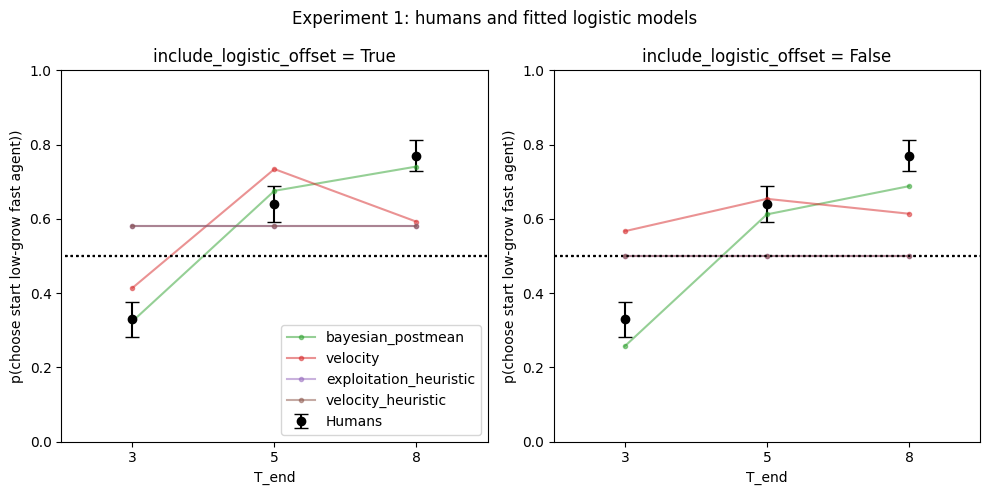

In [9]:
# Another visualization method
# Experiment 2B logistic choice probs
n_questions = 3
beta = 5
T_ends_complete = [range(3,11)]
t_nows_complete = 2*np.ones((len(T_ends_complete))).astype(int)
agent_names = ["Velocity","Exploitation"]
logistic_probs_stay = np.zeros((2, len(models), len(T_ends)))
            
fig,ax = plt.subplots(1,2, figsize=(10,5))
subplot_count = -1
for include_offset_param_val in [True,False]:
    subplot_count = subplot_count+1;
    
    # Load data
    if(include_offset_param_val):
        suffix_offset = "_offset"
    else:
        suffix_offset = "_nooffset"
    filename = "exp1_fits_logistic_heuristics"+suffix_offset
    with open(os.path.join(fitspath,filename+'.pickle'), 'rb') as handle:
        b = pickle.load(handle)
    best_params_fitted = b["best_params_fitted"]
    crossentropy_fitted = b["crossentropy_fitted"]
    data = b["data"]
    models = b["models"]
    include_offset_param = b["include_offset_param"]
    print(best_params_fitted)
    
    
    # Visualize fits
    for forced_agent in range(1):
        ax[subplot_count].errorbar(range(n_questions),choices_mean, yerr=choices_sem, fmt='-o',color="k", linestyle="", capsize=5, label="Humans")
        for model_idx in range(len(models)):
            start_agent = start_agents[forced_agent]
            for task in range(len(T_ends)):
                t_now = t_nows[task]
                T_end = T_ends[task]
                logistic_probs_stay[forced_agent, model_idx, task] = prob_choose_velocity_logistic(theta=best_params_fitted[model_idx,:], T_end=T_end, t_now=t_now, include_offset_param=include_offset_param, start_agent=start_agent, model=models[model_idx])

            ax[subplot_count].plot(range(n_questions), logistic_probs_stay[forced_agent, model_idx,:], ".-", color="C"+str(model_idx+2), alpha=0.5, label=models[model_idx])
            ax[subplot_count].plot([-1,3],[0.5,0.5], "k:")
            ax[subplot_count].set_ylabel("p(choose start low-grow fast agent))")
            ax[subplot_count].set_ylim([0,1])
            ax[subplot_count].set_xlim([-0.5,2.5])
            ax[subplot_count].set_xticks([0,1,2])
            ax[subplot_count].set_xticklabels([3,5,8])
            ax[subplot_count].set_xlabel("T_end")
            ax[subplot_count].set_title("include_logistic_offset = "+str(include_offset_param))

        ax[0].legend()
fig.suptitle("Experiment 1: humans and fitted logistic models")
fig.tight_layout()
#plt.savefig(os.path.join(figpath,"exp1_modelfits_logistic_heuristics"), dpi=300)
plt.show()

## Model comparison: CV

In [12]:
import numpy as np
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5

# Initialize KFold
seed = 1
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)


prob_stay_folds_train = np.zeros((k_folds,n_questions))
n_stay_folds_train_nsubjs = np.zeros((k_folds,n_questions))
prob_stay_folds_test = np.zeros((k_folds,n_questions))
n_stay_folds_test_nsubjs = np.zeros((k_folds,n_questions))

# Create train-test splits for each column/question independently
folds = []
col_data = range(choices.shape[0]*choices.shape[1])
fold_idx=-1
for train_idx, test_idx in kf.split(col_data):
    fold_idx = fold_idx+1
    #print(train_idx.shape)
    for question in range(n_questions):
        relevant_train_idx = np.where((train_idx>=(question)*n_subj) * (train_idx<(question+1)*n_subj)==1)[0]
        relevant_test_idx = np.where((test_idx>=(question)*n_subj) * (test_idx<(question+1)*n_subj)==1)[0]
        prob_stay_folds_train[fold_idx,question] = np.mean(choices[train_idx[relevant_train_idx]-(question)*n_subj,question])
        prob_stay_folds_test[fold_idx,question] = np.mean(choices[test_idx[relevant_test_idx]-(question)*n_subj,question])
        n_stay_folds_train_nsubjs[fold_idx,question] = len(relevant_train_idx)
        n_stay_folds_test_nsubjs[fold_idx,question] = len(relevant_test_idx)

# Print p(stay) statistics for train and test datasets
print(prob_stay_folds_train)
print(prob_stay_folds_test)
print(n_stay_folds_train_nsubjs)
        


[[0.32098765 0.7        0.78481013]
 [0.34177215 0.64102564 0.77108434]
 [0.31707317 0.625      0.76923077]
 [0.34177215 0.62962963 0.775     ]
 [0.32911392 0.60493827 0.75      ]]
[[0.36842105 0.4        0.71428571]
 [0.28571429 0.63636364 0.76470588]
 [0.38888889 0.7        0.77272727]
 [0.28571429 0.68421053 0.75      ]
 [0.33333333 0.78947368 0.85      ]]
[[81. 80. 79.]
 [79. 78. 83.]
 [82. 80. 78.]
 [79. 81. 80.]
 [79. 81. 80.]]


In [13]:
# CV fit on training folds.
T_ends = [3,5,8]
t_nows = [0,0,0]
start_agents=["velocity"]
models = ["bayesian_postmean","velocity","exploitation_heuristic","velocity_heuristic"]
n_inits = 10


params_init = np.zeros((len(models)*2,k_folds, n_inits, 3))
params_init[:] = np.nan
params_fitted = np.zeros((len(models)*2, k_folds,n_inits, 3))
params_fitted[:] = np.nan
crossentropy_fitted = np.zeros((len(models)*2,k_folds, n_inits))
    
model_count = -1
for include_offset_param in [True,False]:
    if(include_offset_param):
        lb = [1e-3, 1e-3, -10]
        ub = [1.5, 50, 10]
        suffix_offset = "_offset"
    else:
        lb = [1e-3, 1e-3]
        ub = [1.5, 50]
        suffix_offset = "_nooffset"

    constraint = scipy.optimize.Bounds(lb=lb, ub=ub)

    for model_idx in range(len(models)):
        model_count = model_count+1;
        model = models[model_idx]
        for fold_idx in range(k_folds):
            print(model, include_offset_param,fold_idx)
            n_subjs_fold = n_stay_folds_train_nsubjs[fold_idx,:]
            n_stay_fold = n_subjs_fold * prob_stay_folds_train[fold_idx,:]
            for rand_init_idx in range(n_inits):
                print(rand_init_idx)
                params_init[model_count, fold_idx, rand_init_idx,0:len(lb)] = np.random.uniform(low=lb, high=ub)
                res = scipy.optimize.minimize(crossentropy_loss, np.squeeze(params_init[model_count,fold_idx, rand_init_idx,0:len(lb)]), bounds=constraint, 
                                          args = (T_ends, t_nows, start_agents, model, n_stay_fold, n_subjs_fold, include_offset_param), method='L-BFGS-B', options={'disp': True})
                params_fitted[model_count,fold_idx,rand_init_idx,0:len(lb)] = res.x
                crossentropy_fitted[model_count,fold_idx,rand_init_idx] = res.fun
            


bayesian_postmean True 0
0


C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


1
2
3
4
5
6
7
8
9
bayesian_postmean True 1
0
1
2
3
4
5
6
7
8
9
bayesian_postmean True 2
0
1
2
3
4
5
6
7
8
9
bayesian_postmean True 3
0
1
2
3
4
5
6
7
8
9
bayesian_postmean True 4
0
1
2
3
4
5
6
7
8
9
velocity True 0
0
1
2
3
4
5
6
7
8
9
velocity True 1
0
1
2
3
4
5
6
7
8
9
velocity True 2
0
1
2
3
4
5
6
7
8
9
velocity True 3
0
1
2
3
4
5
6
7
8
9
velocity True 4
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 0
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 1
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 2
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 3
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 4
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 0
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 1
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 2
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 3
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 4
0
1
2
3
4
5
6
7
8
9
bayesian_postmean False 0
0
1
2
3
4
5
6
7
8
9
bayesian_postmean False 1
0
1
2
3
4
5
6
7
8
9
bayesian_postmean False 2
0
1
2
3
4
5
6
7
8
9
baye

In [16]:
# Compute test loss on left-out folds.
best_params_fitted = np.zeros((len(models)*2, k_folds,3))
crossentropy_testloss = np.zeros((len(models)*2, k_folds))
best_params_fitted[:] = np.nan
model_count = -1
for include_offset_param in [True,False]:
    for model_idx in range(len(models)):
        model_count = model_count+1;
        model = models[model_idx]
        for fold_idx in range(k_folds):
            print(model, include_offset_param,fold_idx)
            n_subj_fold = n_stay_folds_test_nsubjs[fold_idx,:]
            n_stay_fold = n_subj_fold * prob_stay_folds_test[fold_idx,:]
            bestfit_idx_bymodel = np.argmin(crossentropy_fitted[model_count,fold_idx,:])
            best_params_fitted[model_count,fold_idx,:] = params_fitted[model_count,fold_idx,bestfit_idx_bymodel,:]
            crossentropy_testloss[model_count, fold_idx] = crossentropy_loss(theta=best_params_fitted[model_count,fold_idx,:], T_ends=T_ends, t_nows=t_nows, start_agents=start_agents, model=model, true_n_stay=n_stay_fold, n_subjs=n_subj_fold, include_offset_param=include_offset_param)

# Save the CV results
import pickle
filename = "exp1_fits_logistic_heuristics_cv"
a = {"k_folds":k_folds, "crossentropy_testloss":crossentropy_testloss, "prob_stay_folds_train":prob_stay_folds_train, "prob_stay_folds_test":prob_stay_folds_test, "n_stay_folds_train_nsubjs":n_stay_folds_train_nsubjs,"n_stay_folds_test_nsubjs":n_stay_folds_test_nsubjs, 'params_init':params_init,'params_fitted':params_fitted, 'best_params_fitted':best_params_fitted, 'crossentropy_fitted':crossentropy_fitted, 'models':models, 'include_offset_param':[True,False], 'mturk_IDs': mturk_IDs, 'data_dims': ["subject","question (T_end = 3,5,8 in this order)"], 'data': choices, "cv_seed":seed}
with open(os.path.join(fitspath,filename+'.pickle'), 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

bayesian_postmean True 0
bayesian_postmean True 1
bayesian_postmean True 2
bayesian_postmean True 3
bayesian_postmean True 4
velocity True 0
velocity True 1


C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_10140\1249171889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


velocity True 2
velocity True 3
velocity True 4
exploitation_heuristic True 0
exploitation_heuristic True 1
exploitation_heuristic True 2
exploitation_heuristic True 3
exploitation_heuristic True 4
velocity_heuristic True 0
velocity_heuristic True 1
velocity_heuristic True 2
velocity_heuristic True 3
velocity_heuristic True 4
bayesian_postmean False 0
bayesian_postmean False 1
bayesian_postmean False 2
bayesian_postmean False 3
bayesian_postmean False 4
velocity False 0
velocity False 1
velocity False 2
velocity False 3
velocity False 4
exploitation_heuristic False 0
exploitation_heuristic False 1
exploitation_heuristic False 2
exploitation_heuristic False 3
exploitation_heuristic False 4
velocity_heuristic False 0
velocity_heuristic False 1
velocity_heuristic False 2
velocity_heuristic False 3
velocity_heuristic False 4


[37.02724448 38.84116094 41.02857671 41.02857673 37.31820398 40.14516541
 41.59078467 41.58883083]
[0.296895   0.52091954 0.85631401 0.85631403 0.26474308 0.43243798
 1.29885202 1.29829051]

Paired t-test, bayesian_postmean vs velocity_offset: p=0.0014289217818114765
Paired t-test, bayesian_postmean vs exploitation_heuristic_offset: p=0.02348450161589192
Paired t-test, bayesian_postmean vs velocity_heuristic_offset: p=0.023484503237150046
Paired t-test, bayesian_postmean vs bayesian_postmean_nooffset: p=0.5885981718548194
Paired t-test, bayesian_postmean vs velocity_nooffset: p=0.0075874645324224286
Paired t-test, bayesian_postmean vs exploitation_heuristic_nooffset: p=0.04418454379162984
Paired t-test, bayesian_postmean vs velocity_heuristic_nooffset: p=0.04419424164206629


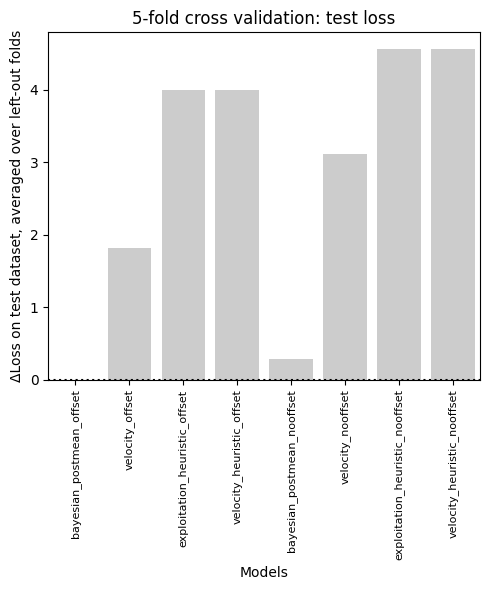

In [17]:
model_fullnames = ["bayesian_postmean_offset","velocity_offset", "exploitation_heuristic_offset","velocity_heuristic_offset","bayesian_postmean_nooffset","velocity_nooffset", "exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]

filename = "exp1_fits_logistic_heuristics_cv"
with open(os.path.join(fitspath,filename+'.pickle'), 'rb') as handle:
    b = pickle.load(handle)
    k_folds = b["k_folds"]
    crossentropy_testloss = b["crossentropy_testloss"]
    
# 2) Average over folds for each subject, then sum over subjects.
crossentropy_cv = np.mean(crossentropy_testloss,axis=1)
print(crossentropy_cv)
crossentropy_cv_sem = np.nanstd(crossentropy_testloss-np.min(crossentropy_testloss,axis=0)[None,:], ddof=1, axis=1) / np.sqrt(k_folds) # Errorbars are SEM over 
print(crossentropy_cv_sem)
print()

# 3) Paired t-test and Wilcoxon test
for model_idx in range(1,len(model_fullnames)):
    t_stat, p_value = scipy.stats.ttest_rel(crossentropy_testloss[0,:], crossentropy_testloss[model_idx,:])
    print("Paired t-test, bayesian_postmean vs "+model_fullnames[model_idx]+": p={0}".format(p_value))
    
# 4) Visualize
fig, ax = plt.subplots(1,1,figsize=(5,6))
ax.bar(range(len(model_fullnames)), crossentropy_cv-np.min(crossentropy_cv), color="k", alpha=0.2)
yerr = crossentropy_cv_sem
ax.plot([-0.5,len(model_fullnames)-1+0.5],[0,0],"k:")
ax.set_xlim([-0.5,len(model_fullnames)-1+0.5])
ax.set_ylabel("ΔLoss on test dataset, averaged over left-out folds")
ax.set_xlabel("Models")
ax.set_xticks(range(len(model_fullnames)))
ax.set_xticklabels(model_fullnames, fontsize=8)
ax.tick_params(axis='x', labelrotation=90) 
ax.set_title(str(k_folds)+"-fold cross validation: test loss")
fig.tight_layout()
#plt.savefig(os.path.join(figpath,"exp1_"+str(k_folds)+"foldcv_testloss"), dpi=300)
plt.show()